# Brief Description of the Problem and Data
Metastasis occurs when rapidly dividing cancer cells break free from their tissue of origin and enter the bloodstream or lymphatic system. This is of concern in the diagnosis and treatment of cancer because once these cancer cells begin to travel around the body, they can cause the formation of tumors and other issues elsewhere within the body.

The goal of this Kaggle challenge is to take low-resolution (96 x 96 pixel RGB) images and use them to predict the presence or absence of metastatic cancer tissue in a biopsy sample. Training and testing sets are a combination of images and a CSV file with filenames and binary labels. The training data has actual labels while the testing data has dummy labels (all 0s) to provide formatting guidelines for submission back to Kaggle.

Per the Kaggle challenge details, while the provided images are all 96x96 pixels, the binary categorization is for the presence or absence of a pixel misrepresenting metastasis in the center 32x32 pixel region. If a single pixel has metastasis, that image is considered to be a positive (i.e. “1”), otherwise it’s a negative (i.e. “0”).

Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
import os

import glob

import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import regularizers, optimizers

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

Verify GPU is Accessible to TensorFlow

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Load the Training Label Data

In [3]:
train_df = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")
train_df.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Clean the Data by converting the labels from digits into strings (for some reason that's required in the Keras procedures I'm using) and adding file extensions ot the IDs.

In [4]:
train_df["label"] = train_df["label"].astype(str)
train_df["id"] = train_df["id"] + ".tif"
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Count and visualize the number of positive and negatives and verify each row has a unique id.

<AxesSubplot:>

Count negatives: 130908
Count positives: 89117
Count total: 220025
Unique ids: 220025


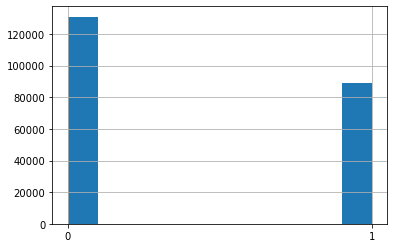

In [5]:
display(train_df["label"].hist())
print(f"Count negatives: {train_df['label'].loc[train_df['label'] == '0'].count()}")
print(f"Count positives: {train_df['label'].loc[train_df['label'] == '1'].count()}")
print(f"Count total: {train_df['label'].count()}")
print(f"Unique ids: {len(train_df['id'].unique())}")

(Helper variables.)

In [6]:
seed_val = 0
validation_proportion = 0.2
batch_size = 1024
target_size = (96,96)

Image data will be loaded in two ways.<br>
First, an ImageDataGenerator will be created to performa  train/test split (80:20).<br>
Then, a (very) small subset of the images will be loaded using openCV to visualize and verify consistency on data dimensions.

In [7]:
datagen = ImageDataGenerator(rescale = 1.0/255.0, validation_split = validation_proportion)
train_generator = datagen.flow_from_dataframe(
    dataframe = train_df, 
    directory = "histopathologic-cancer-detection/train", 
    x_col = "id", y_col = "label", 
    class_mode = "binary", 
    target_size = target_size, 
    color_mode = "rgb", 
    batch_size = batch_size, 
    seed = seed_val, 
    shuffle = True, 
    subset = "training", 
    validation_split = validation_proportion
)
valid_generator = datagen.flow_from_dataframe(
    dataframe = train_df, 
    directory = "histopathologic-cancer-detection/train", 
    x_col = "id", y_col = "label", 
    class_mode = "binary", 
    target_size = target_size, 
    color_mode = "rgb", 
    batch_size = batch_size, 
    seed = seed_val, 
    shuffle = True, 
    subset = "validation", 
    validation_split = validation_proportion
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


{(96, 96, 3)}


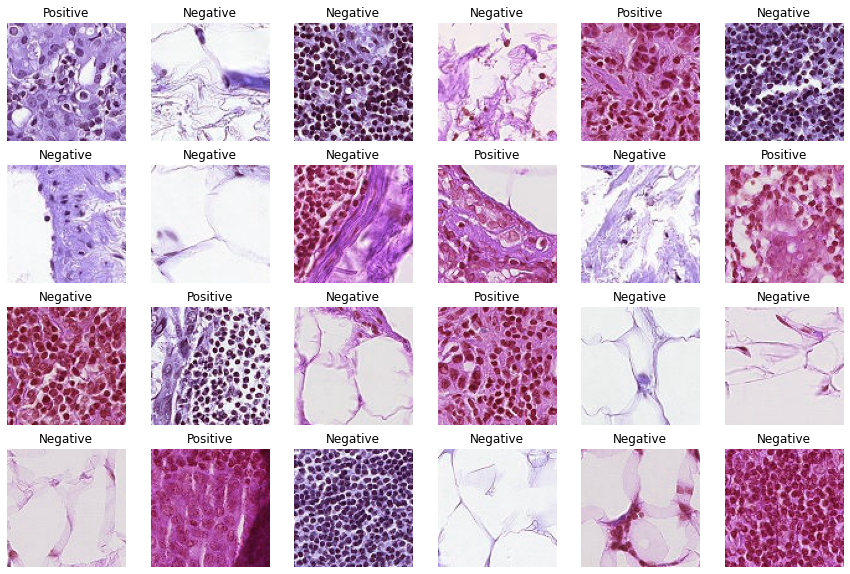

In [8]:
img_paths = glob.glob("histopathologic-cancer-detection/train/*")
preview_image_paths = img_paths[0:(6*4)]
preview_imgs = [cv2.imread(p) for p in preview_image_paths]
ncols = 6
nrows = int(np.ceil(len(preview_image_paths)/ncols))

fig = plt.figure(figsize = (15,10))

i=0
for r in range(nrows):
    for c in range(ncols):
        i = i+1
        fig.add_subplot(nrows,ncols,i)
        plt.imshow(preview_imgs[i-1])
        plt.axis("off")
        title_text = train_df.loc[train_df["id"] == preview_image_paths[i-1][-44:], "label"].values[0]
        plt.title("Positive" if title_text == "1" else "Negative")
        
print(set([img.shape for img in preview_imgs]))

The images are all 96x96 pixel, 3-channel (RGB) data.<br>
I'm not a pathologist, so I have no clue what features in an image are indicative of metastisis.<br>
...but I bet a convolutional neural network will find something.

# Model Architecture

Deciding on a CNN model architecture is a balancing act between the size of the input data at each layer and the number of convolutions that need to be trained.<br>
I started with fewer convolutions and then increased them (32, then 64, then 128) with pooling and drop-out after each layer.<br>
Then everything's flattened before being fed into dense layers of decreasing size until the size is eventually 1 (since this is binary classification).<br>
Rectified linear units are used as the activation function until the last layer, which is sigmoid. This selection of activation functions was chosen because ReLU will back-propogate quickly but sigmoid handles binaries well.<br>
Before settling on the model below, I tested several combinations of convolution size, number of dense layers, and whether or not pooling and dropout was included.<br>
Below is the consuction, summary, and training performance of the model I settled on.

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = (96,96,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, kernel_size = (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.20))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.20))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.20))

model.add(Dense(1, activation = "sigmoid"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 64)        0

In [11]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history = model.fit(
    train_generator,
    validation_data = train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    epochs = 20)

Epoch 1/20
171/171 [==============================] - 557s 3s/step - loss: 0.5336 - accuracy: 0.7378 - val_loss: 0.5165 - val_accuracy: 0.7691
Epoch 2/20
171/171 [==============================] - 89s 520ms/step - loss: 0.4450 - accuracy: 0.7991 - val_loss: 0.4373 - val_accuracy: 0.8102
Epoch 3/20
171/171 [==============================] - 87s 506ms/step - loss: 0.4115 - accuracy: 0.8181 - val_loss: 0.4881 - val_accuracy: 0.7714
Epoch 4/20
171/171 [==============================] - 89s 517ms/step - loss: 0.3967 - accuracy: 0.8262 - val_loss: 0.4294 - val_accuracy: 0.8083
Epoch 5/20
171/171 [==============================] - 87s 506ms/step - loss: 0.3637 - accuracy: 0.8435 - val_loss: 0.4317 - val_accuracy: 0.8039
Epoch 6/20
171/171 [==============================] - 88s 514ms/step - loss: 0.3382 - accuracy: 0.8564 - val_loss: 0.3371 - val_accuracy: 0.8592
Epoch 7/20
171/171 [==============================] - 87s 508ms/step - loss: 0.3241 - accuracy: 0.8635 - val_loss: 0.2967 - val_accu

# Results and Analysis

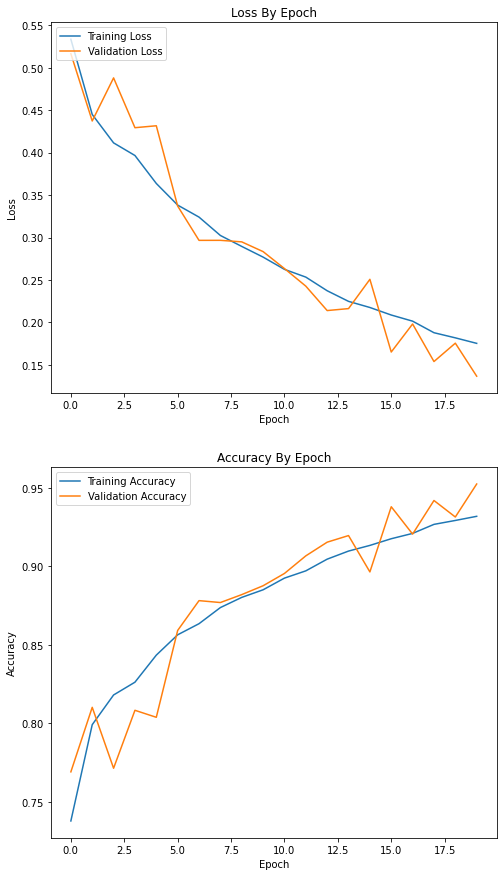

In [12]:
fig, ax = plt.subplots(2,1, figsize = (8,15))
#Plot Loss Data
ax[0].set_title("Loss By Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].plot(history.epoch, history.history["loss"], label = "Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label = "Validation Loss")
ax[0].legend(loc = 2)
#Plot Accuracy Data
ax[1].set_title("Accuracy By Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].plot(history.epoch, history.history["accuracy"], label = "Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label = "Validation Accuracy")
ax[1].legend(loc = 2)

As you would expect, loss generally decreases for both training and validation after successive epochs, and accuracy increases toward a plateau (I'd guess somewhere in the neighborhood of 95%).<br>
When I tested fewer epochs, I got worse accuracy, but more epochs didn't seem to have a significant improvement in performance.<br>
<b>On a relatively powerful, GPU-enabled computer, each run of this model takes over 45 minutes, so for a nominally 12-hour long assignment, there's a finite quantity of relevant hyper-parameter testing I'm willing to engage in (especially considering that getting Keras, Tensorflow, CUDA, CUDNN, and the questionable mystery DLL file Nvidia instructed me to download from an ancient website on another domain took over 8 hours in total).
    <br>
Additionally, the requirement to run this in a Jupyter notebook meant each iteration's output overwrote the previous iteration's, so the record of developmental probing into hyperparameters is lost.</b>    <br>
The next step was to use the trained model to predict values for the Kaggle test set, format the output, upload it to Kaggle, and get an accuracy measure from Kaggle, which can only be done a finite number of times per day and excessive testing for hyperparameter tuning is not in the spirit of Kaggle challenges.<br>
Note that the outputs from the model are rounded (which binarizes them along a 0.5 split), the labels are modified to fit the original format (i.e. without file extensions), and the predictions are written to a CSV for upload.

In [13]:
kaggle_df = pd.read_csv("histopathologic-cancer-detection/sample_submission.csv")
kaggle_df["label"] = kaggle_df["label"].astype(str)
kaggle_df["id"] = kaggle_df["id"] + ".tif"
kaggle_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [14]:
kaggle_dataset = ImageDataGenerator(rescale = 1.0/255.0)
kaggle_generator = kaggle_dataset.flow_from_dataframe(
    dataframe = kaggle_df,
    directory = "histopathologic-cancer-detection/test",
    x_col = "id",
    y_col = None,
    batch_size = 1,
    seed = seed_val,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)
kaggle_pred = model.predict(
    kaggle_generator, 
    steps = kaggle_generator.n,
    verbose = 1
)

Found 57458 validated image filenames.
57458/57458 [==============================] - 200s 3ms/step


In [15]:
kaggle_pred_rounded = np.round(kaggle_pred).astype(int)
kaggle_pred_str = [str(i[0]) for i in kaggle_pred_rounded]

In [16]:
kaggle_pred_df = kaggle_df.copy()
kaggle_pred_df["label"] = kaggle_pred_str
kaggle_pred_df["id"] = kaggle_pred_df["id"].str.replace(".tif","", regex=False)
kaggle_pred_df.to_csv("kaggle_predictions.csv", header=True, sep=",", index=False)

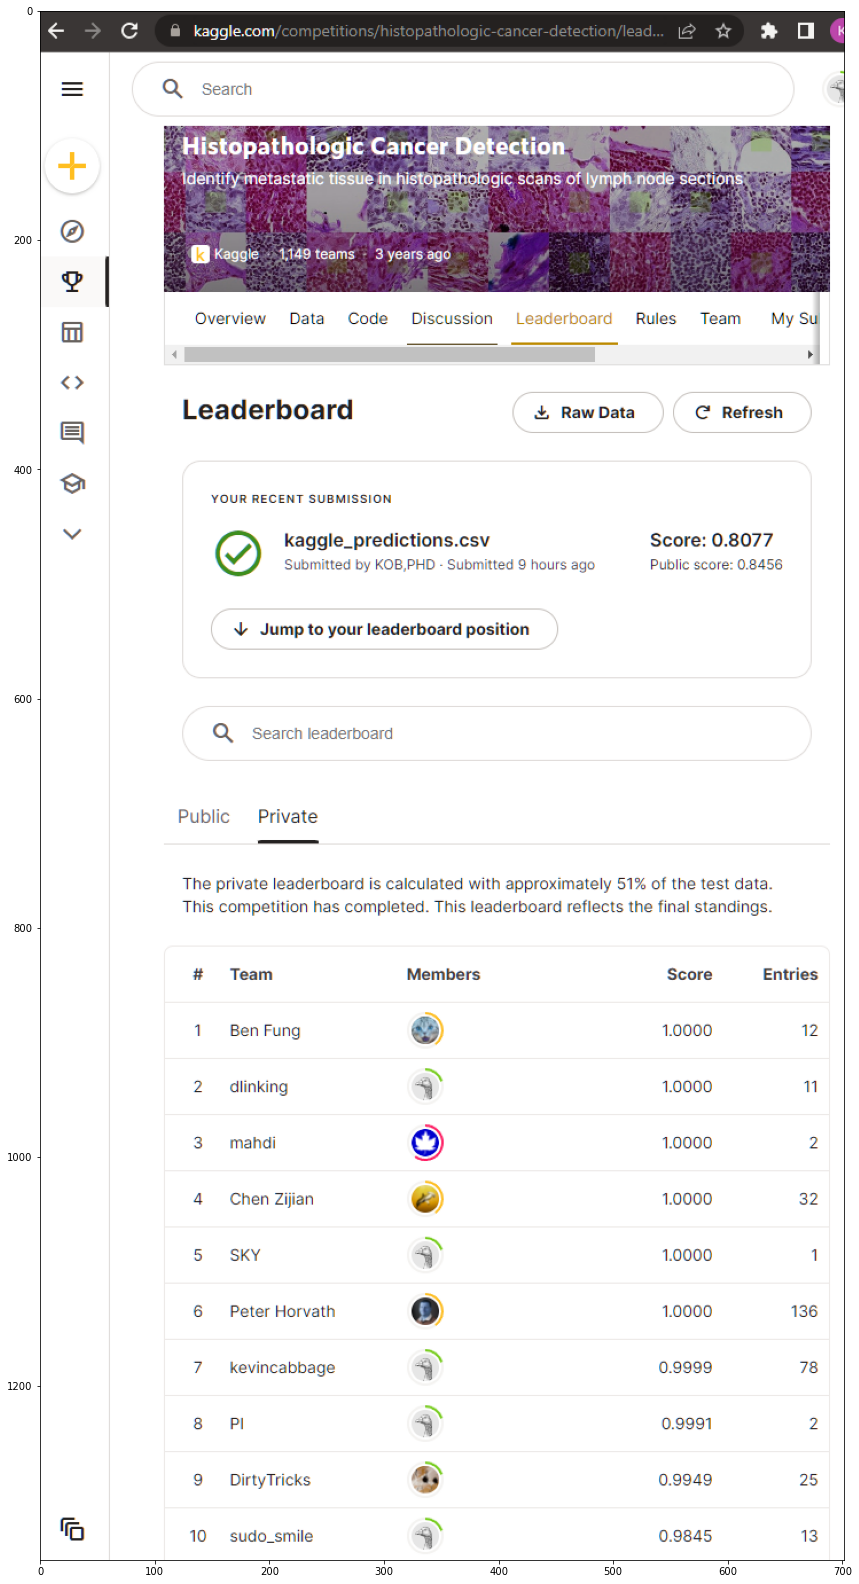

In [20]:
kaggle_performance_screenshot = cv2.imread("Kaggle_Screenshot.png")
plt.figure(figsize = (15,15*1.9))
plt.imshow(kaggle_performance_screenshot)

# Conclusion

Setting the initial number of convolutions too high made model training time prohibitively long (on the order of multiple hours for the first epoch) for a course assignment, but setting them too low resulted in poor accuracy (I often saw less than 70% in the training data).<br>
Model training time increased with deeper networks, but performance generally increased, too.<br>
Unfortunately, with no real sense of what does and doesn’t provide visual indication of metastasis to expert human observers, I was unable to do any pre-neural-network manipulations of the images to accentuate relevant features.<br>
While the performance, relatively to development time, of this model is impressive, the accuracy is nowhere near enough (especially in the Kaggle test set) to be clinically useful.<br>
I would be very interested to see how, instead of a binary classification, percentage of metastatic tissue could be predicted.
Additionally, I’d be interested to see if any of the vast array of features in OpenCV can be used to pre-process the images to improve accuracy. Since those tissue samples are most likely stained, it’s also possible that an alternative photographic technique (or different illumination or optical filtration) may be a good adjunct to image adjustments.<br>
I’m interested in using convolutional neural networks again in the future, but I would definitely want a better sense of relevant features in the data for future applications.